In [1]:
import pandas as pd
import os
import json
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [3]:
def get_demography_df():
    files = os.listdir("data/demography/")
    entries = []
    for file in tqdm(files):
        with open(f"data/demography/{file}","r") as f:
            entry = json.load(f)
            entry["frame_id"] = int(file.split("_")[1])
            entries.append(entry)
    demography_df = pd.DataFrame(entries)
    return demography_df

In [4]:
demo_df = get_demography_df()

100%|████████████████████████████████████████████████████████████████████████████| 1127/1127 [00:00<00:00, 2289.42it/s]


In [5]:
demo_df.head()

,emotion,dominant_emotion,region,face_confidence,age,gender,dominant_gender,race,dominant_race,frame_id
0,"{'angry': 0.07739887564168878, 'disgust': 2.20...",sad,"{'x': 191, 'y': 157, 'w': 168, 'h': 292, 'left...",1.00,31,"{'Woman': 22.41971045732498, 'Man': 77.5802910...",Man,"{'asian': 1.7354777289006387, 'indian': 1.1071...",white,10005
1,"{'angry': 0.05867492408528019, 'disgust': 9.89...",sad,"{'x': 196, 'y': 138, 'w': 163, 'h': 295, 'left...",1.00,30,"{'Woman': 16.770778596401215, 'Man': 83.229219...",Man,"{'asian': 4.841800034046173, 'indian': 3.40968...",white,10020
2,"{'angry': 3.0267726747068555, 'disgust': 2.485...",neutral,"{'x': 205, 'y': 115, 'w': 163, 'h': 276, 'left...",1.00,31,"{'Woman': 13.677968084812164, 'Man': 86.322033...",Man,"{'asian': 1.998317427933216, 'indian': 1.90386...",white,10035
3,"{'angry': 1.7797511020489765e-06, 'disgust': 1...",neutral,"{'x': 344, 'y': 80, 'w': 153, 'h': 288, 'left_...",0.98,33,"{'Woman': 93.70995759963989, 'Man': 6.29003867...",Woman,"{'asian': 0.13043524231761694, 'indian': 0.189...",white,10050
4,"{'angry': 17.719951272010803, 'disgust': 7.726...",neutral,"{'x': 349, 'y': 72, 'w': 153, 'h': 304, 'left_...",0.99,33,"{'Woman': 95.17351388931274, 'Man': 4.82648648...",Woman,"{'asian': 1.2738639488816261, 'indian': 2.4188...",white,10065


In [6]:
temp_df = pd.DataFrame(demo_df.dominant_emotion.value_counts(normalize=True)*100).reset_index()

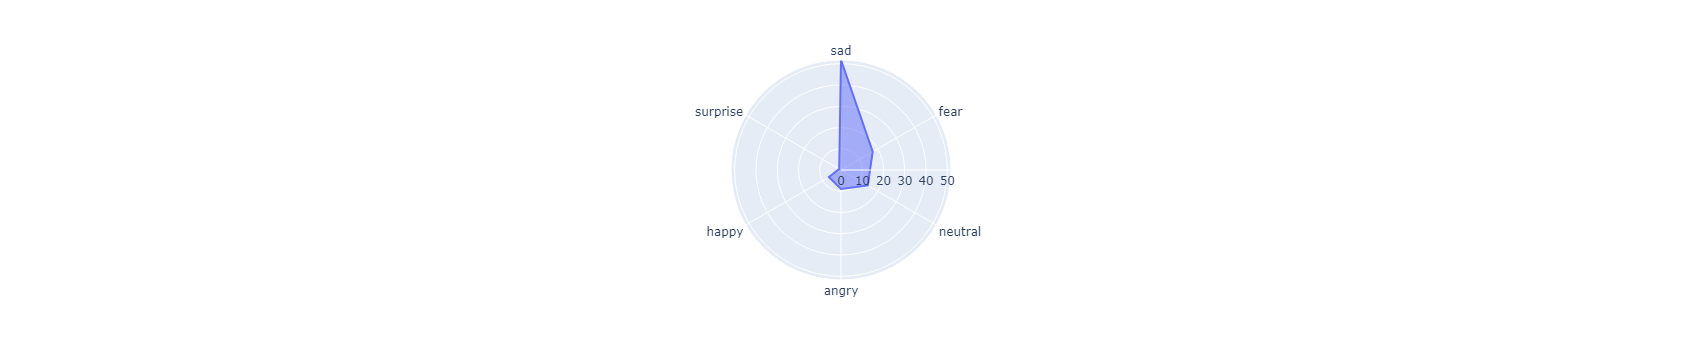

In [7]:
fig = px.line_polar(temp_df, r='proportion', theta='dominant_emotion', line_close=True)
fig.update_traces(fill='toself')
fig.show()

In [8]:
temp_df

,dominant_emotion,proportion
0,sad,51.730257
1,fear,17.213842
2,neutral,14.551908
3,angry,8.961846
4,happy,6.566105
5,surprise,0.976043


In [9]:
race_df = (demo_df.dominant_race.value_counts(normalize=True) * 100).reset_index()

In [10]:
demo_df.dominant_emotion.value_counts()

dominant_emotion
sad         583
fear        194
neutral     164
angry       101
happy        74
surprise     11
Name: count, dtype: int64

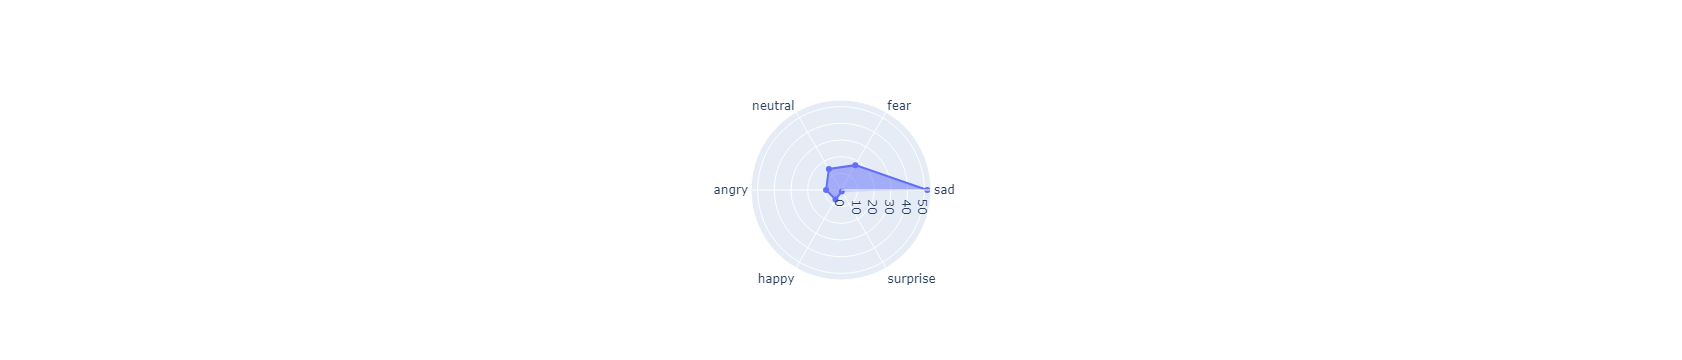

In [11]:
fig = go.Figure(data=go.Scatterpolar(
  r=temp_df["proportion"],
  theta=temp_df["dominant_emotion"],
  fill='toself'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)


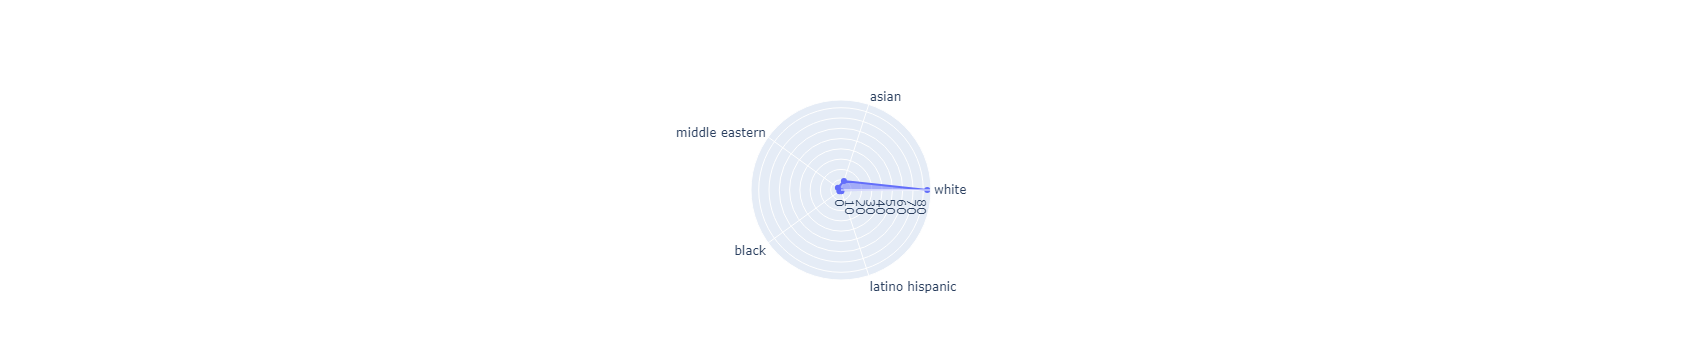

In [52]:
fig = go.Figure(data=go.Scatterpolar(
  r=race_df["proportion"],
  theta=race_df["dominant_race"],
  fill='toself'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)


In [97]:
from dash import Dash, dcc, html
import dash_mantine_components as dmc
from dash.dependencies import Input, Output

In [126]:
app = Dash()

In [127]:
# Callback to update the graph based on the slider
@app.callback(
    Output('spider-graph', 'figure'),
    Input('frame-slider', 'value'),
    Input('spider-chart-radio-btn', 'value'))
def update_graph(selected_range, col_radio):
    # Compute min and max frame_id
    min_frame_id = demo_df['frame_id'].min()
    max_frame_id = demo_df['frame_id'].max()
    range_frame_id = max_frame_id - min_frame_id
    
    # Convert percentage slider values to frame_id range
    start_id = min_frame_id + (selected_range[0] / 100.0) * range_frame_id
    end_id = min_frame_id + (selected_range[1] / 100.0) * range_frame_id
    
    # Filter the DataFrame based on the calculated frame_id range
    filtered_df = demo_df[(demo_df['frame_id'] >= start_id) & (demo_df['frame_id'] <= end_id)]
    
    specific_df = pd.DataFrame(filtered_df[col_radio].value_counts(normalize=True)*100).reset_index()
    # Create the figure
    fig = go.Figure(data=go.Scatterpolar(
        r=specific_df['proportion'],
        theta=specific_df[col_radio],
        fill='toself'
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True
            ),
        ),
        showlegend=False
    )
    
    return fig

In [128]:

app.layout = html.Div([
    dcc.RangeSlider(
        id='frame-slider',
        min=0,
        max=100,
        value=[0, 100],
        step=5,  # Percentage step
        marks={i: f'{i}%' for i in range(0, 101, 10)}
    ),
    dcc.RadioItems(
        id='spider-chart-radio-btn',
        options=[
            {'label': 'race', 'value': 'dominant_race'},
            {'label': 'emotion', 'value': 'dominant_emotion'}
        ],
        value='dominant_race',  # Default value
    ),
    dcc.Graph(id='spider-graph'),
    dcc.Graph(id='line-graph-evolution')
    
])

In [129]:
app.run(debug=True)